<a href="https://colab.research.google.com/github/ElaYJ/Study_Deep_Learning/blob/main/Lecture/PyTorch_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture

## 예제: 수식

In [ ]:
import torch

In [ ]:
# torch.tensor(
#     data: Any,
#     dtype: _dtype | None = None,
#     device: DeviceLikeType | None = None,
#           device is one of cpu, cuda, ipu, xpu, mkldnn, opengl, opencl,
#           ideep, hip, ve, fpga, ort, xla, lazy, vulkan, mps, meta, hpu, mtia,
#           privateuseone device type at start of device string
#     requires_grad: _bool = False,
#     pin_memory: _bool = False
# ) -> Tensor
x = torch.tensor(3.5, requires_grad=True)
x

tensor(3.5000, requires_grad=True)

In [ ]:
y = (x - 1) * (x - 2) * (x - 3)
y

tensor(1.8750, grad_fn=<MulBackward0>)

In [ ]:
# def backward(gradient=None, retain_graph=None, create_graph=False, inputs=None)

# Computes the gradient of current tensor wrt(with respect to:~에 관하여) graph leaves.
# 이는 현재 텐서의 그래프 상에서 기울기(gradient)를 계산할 때, 해당 그래프의 말단에 있는 노드들에 대한 것을 의미합니다.
# 즉, 그래프의 입력과 관련된 부분에 대한 기울기를 계산하게 됩니다.
# The graph is differentiated using the chain rule.
# If the tensor is non-scalar (i.e. its data has more than one element) and requires gradient,
# the function additionally requires specifying gradient.
# It should be a tensor of matching type and location, that contains the gradient of the differentiated function w.r.t. self.
# This function accumulates gradients in the leaves - you might need to zero .grad attributes or set them to None before calling it.
# See Default gradient layouts<default-grad-layouts> for details on the memory layout of accumulated gradients.

# @Args:
#     gradient (Tensor or None): Gradient w.r.t. the tensor.
#           If it is a tensor, it will be automatically converted to a Tensor that does not require grad unless create_graph is True.
#           None values can be specified for scalar Tensors or ones that don't require grad.
#           If a None value would be acceptable then this argument is optional.
#     retain_graph (bool, optional): If False, the graph used to compute the grads will be freed.
#           Note that in nearly all cases setting this option to True is not needed and often can be worked around in a much more efficient way.
#           Defaults to the value of create_graph.
#     create_graph (bool, optional): If True, graph of the derivative will be constructed,
#           allowing to compute higher order derivative products. Defaults to False.
#     inputs (sequence of Tensor): Inputs w.r.t. which the gradient will be accumulated into .grad.
#           All other Tensors will be ignored.
#           If not provided, the gradient is accumulated into all the leaf Tensors that were used to compute the attr::tensors.
y.backward()

In [ ]:
x.grad

tensor(5.7500)

In [ ]:
a = torch.tensor(2.0, requires_grad=True) # a=2
b = torch.tensor(1.0, requires_grad=True) # b=1

x = 2*a + 3*b
y = 5*a**2 + 3*b**3
z = 2*x + 3*y #--> z = 15a² + 4a + 9b³ + 6b

z.backward()
z

tensor(83., grad_fn=<AddBackward0>)

In [ ]:
# dz/da = 30a + 4
# dz/db = 27b² + 6

a.grad, b.grad

(tensor(64.), tensor(33.))

In [ ]:
a = torch.tensor(2.0, requires_grad=True) # a=2
b = torch.tensor(1.0, requires_grad=True) # b=1

x = 2*a + 3*b
y = 5*a**2 + 3*b**3
z = 2*x + 3*y

z.backward(create_graph=True)
z

tensor(83., grad_fn=<AddBackward0>)

In [ ]:
a.grad, b.grad

(tensor(64., grad_fn=<CopyBackwards>), tensor(33., grad_fn=<CopyBackwards>))

## 예제: 보스턴 집값 예측 - 선형회귀

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn #--> Neural Net
import torch.nn.functional as F #--> NN에서 많이 쓰이는 함수들
import torch.optim as optim #--> 최적화와 관련된 함수들

torch.manual_seed(127)
torch.__version__

'2.2.1+cu121'

In [ ]:
url ='https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/boston.csv'
boston = pd.read_csv(url)

boston.rename(columns={"MEDV": "TARGET"}, inplace=True) # MEDV --> TARGET
boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [ ]:
# 학습에 필요한 특성 선택 후 torch가 학습할 수 있는 자료형으로 변환

cols = ['TARGET', 'INDUS', 'RM', 'LSTAT', 'NOX', 'DIS']

data = torch.from_numpy(boston[cols].values).float() #--> ⭐ 토치의 자료형 습관~!!
data.shape

torch.Size([506, 6])

|col|content|
|---|---|
|MEDV | Median value of owner-occupied homes in \$1000's |
|INDUS | proportion of non-retail business acres per town |
|RM | average number of rooms per dwelling |
|LSTAT | % lower status of the population |
|NOX | nitric oxides concentration (parts per 10 million) |
|DIS | weighted distances to five Boston employment centres |

In [ ]:
data[:3,:], type(data)

(tensor([[24.0000,  2.3100,  6.5750,  4.9800,  0.5380,  4.0900],
         [21.6000,  7.0700,  6.4210,  9.1400,  0.4690,  4.9671],
         [34.7000,  7.0700,  7.1850,  4.0300,  0.4690,  4.9671]]),
 torch.Tensor)

In [ ]:
# 특성과 라벨 분리

y = data[:, :1]
X = data[:, 1:]

X.shape, y.shape

(torch.Size([506, 5]), torch.Size([506, 1]))

In [ ]:
# 모델 수립
# torch.nn.Linear() --> Applies a linear transformation to the incoming data: y = x·A^T + b
# def __init__(in_features: int, out_features: int, bias: bool=True, device=None, dtype=None) -> None

model = nn.Linear(X.size(-1), y.size(-1))
model

Linear(in_features=5, out_features=1, bias=True)

In [ ]:
# model.parameters() --> 'generator' object
next(iter(model.parameters()))

Parameter containing:
tensor([[ 0.1002, -0.4458, -0.0607,  0.0802, -0.1586]], requires_grad=True)

In [ ]:
for p in model.parameters():
    print(p, p.shape, type(p), sep=' / ')

Parameter containing:
tensor([[ 0.1002, -0.4458, -0.0607,  0.0802, -0.1586]], requires_grad=True) / torch.Size([1, 5]) / <class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.2359], requires_grad=True) / torch.Size([1]) / <class 'torch.nn.parameter.Parameter'>


In [ ]:
# Define configurations - hyperparamerters

n_epochs = 3000
learning_rate = 1e-5 #--> 0.00001
print_interval = 1000 #--> 1000번째 epoch 마다 상황 출력

In [ ]:
# 학습

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for i in range(n_epochs):
    y_hat = model(X) #--> y(506,1) = x(506,5)·W^T(5,1) + b(1,)
    loss = F.mse_loss(y_hat, y)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    if (i+1) % print_interval == 0:
        print("Epoch %d: loss=%.4e" % (i+1, loss))
#--> 1000 epoch 이후 loss 값이 변하지 X

Epoch 1000: loss=2.8946e+01
Epoch 2000: loss=2.8946e+01
Epoch 3000: loss=2.8946e+01


In [ ]:
tmp = torch.cat([y, y_hat], dim=1) #--> return type: torch.Tensor
tmp.shape, tmp[:3,:]

(torch.Size([506, 2]),
 tensor([[24.0000, 30.2983],
         [21.6000, 25.3205],
         [34.7000, 32.5631]], grad_fn=<SliceBackward0>))

In [ ]:
torch.cat([y, y_hat], dim=1).detach_().numpy()[:3,:] #--> return type: numpy.ndarray

array([[24.      , 30.298332],
       [21.6     , 25.320484],
       [34.7     , 32.5631  ]], dtype=float32)

In [ ]:
# 학습 결과 정리

df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach_().numpy(), columns=["y", "y_hat"])
df

,y,y_hat
0,24.000000,30.298332
1,21.600000,25.320484
2,34.700001,32.563099
3,33.400002,32.396145
4,36.200001,31.764915
...,...,...
501,22.400000,26.787899
502,20.600000,24.709869
503,23.900000,31.533836
504,22.000000,29.873182


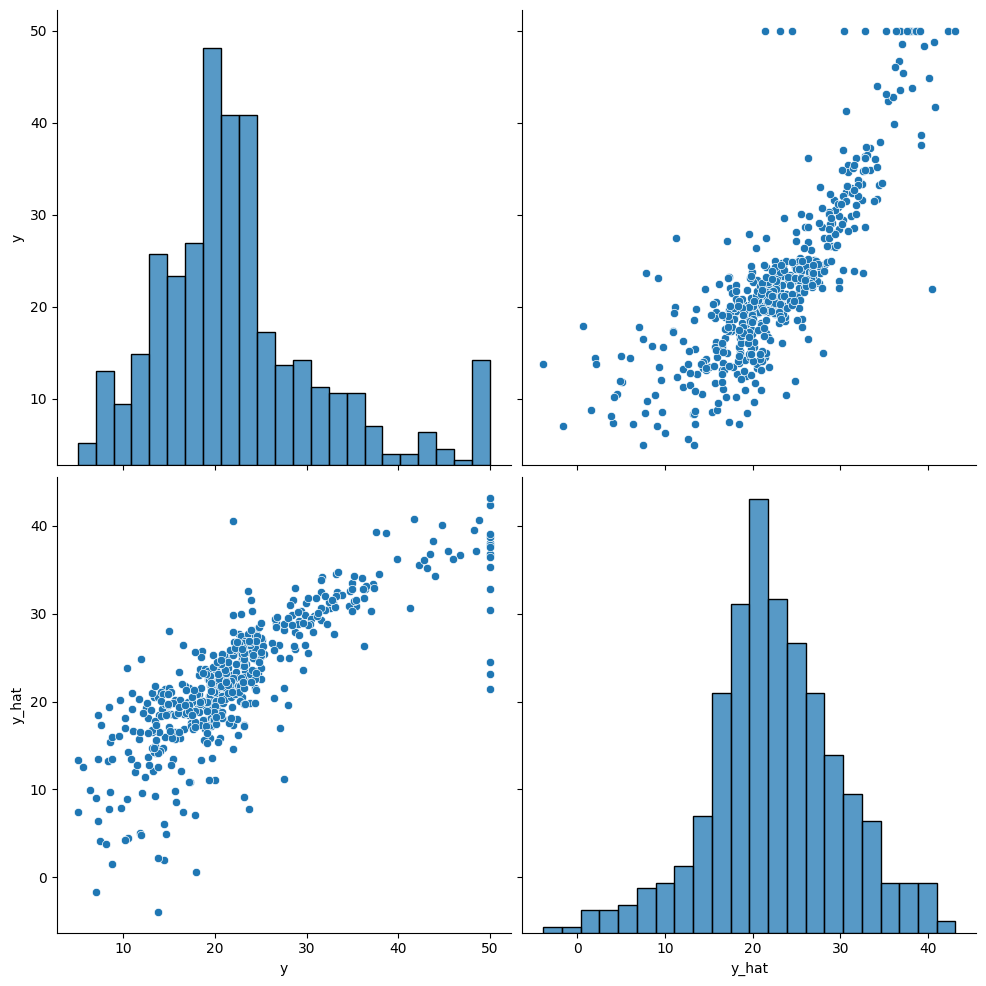

In [ ]:
# 참값 y의 분포 & 예측값 y_hat의 분포
sns.pairplot(df, height=5)
plt.show()

## 예제: 유방암 진단 예측 - 이진분류

In [ ]:
from sklearn.datasets import load_breast_cancer

b_cancer = load_breast_cancer()
bcancel_df = pd.DataFrame(b_cancer.data, columns=b_cancer.feature_names)
bcancel_df['class'] = b_cancer.target
bcancel_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [ ]:
# 관심있는 컬럼 정리 & 확인
cols = ['mean radius', 'mean texture', 'mean smoothness', 'mean compactness', 'mean concave points',
        'worst radius', 'worst texture', 'worst smoothness', 'worst compactness', 'worst concave points',
        'class']
data = torch.from_numpy(bcancel_df[cols].values).float()
data.shape

torch.Size([569, 11])

In [ ]:
# 데이터를 특성과 라벨로 분리

X = data[:, :-1]
y = data[:, -1:]

X.shape, y.shape

(torch.Size([569, 10]), torch.Size([569, 1]))

In [ ]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

        super().__init__() #--> 상속하는 nn.Module의 초기화 함수 호출함으로써 Module의 속성을 상속받는다.

        self.linear = nn.Linear(input_dim, output_dim)
        self.act_func = nn.Sigmoid() #--> 2진 분류이므로 출력단은 시그모이드 함수

    def forward(self, x):
        # |x| = (batch_size, input_dim)
        # |y| = (batch_size, output_dim)
        y = self.act_func(self.linear(x))

        return y

In [ ]:
model = MyModel(input_dim=X.size(-1), output_dim=y.size(-1))
model

MyModel(
  (linear): Linear(in_features=10, out_features=1, bias=True)
  (act_func): Sigmoid()
)

In [ ]:
# Define configurations - 하이퍼파라미터 설정

n_epochs = 200000
learning_rate = 1e-3
print_interval = 50000

In [ ]:
# 학습

# Define BCELoss(Binary Cross Entropy) instead of MSELoss
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for i in range(n_epochs):
    y_hat = model(X)
    loss = criterion(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % print_interval == 0:
        print("Epoch %d: loss=%.4e" % (i+1, loss))

Epoch 50000: loss=1.1487e-01
Epoch 100000: loss=1.1449e-01
Epoch 150000: loss=1.1412e-01
Epoch 200000: loss=1.1375e-01


| epochs | lr=0.01 | lr=0.001 |
|:---:|:---:|:---:|
|  50000 | loss=0.16690 | loss=0.11487 |
| 100000 | loss=0.13522 | loss=0.11449 |
| 150000 | loss=0.12247 | loss=0.11412 |
| 200000 | loss=0.11547 | loss=0.11375 |
| Accuracy | 0.9631 | 0.9649 |

In [ ]:
y.shape, y.size(dim=0), y.size(dim=-1)

(torch.Size([569, 1]), 569, 1)

In [ ]:
# Accuracy 계산

correct_cnt = (y == (y_hat > .5)).sum()
total_cnt = float(y.size(0))

print('Accuracy: %.4f' % (correct_cnt/total_cnt))

Accuracy: 0.9649


## 예제: MNIST - CNN LeNET

- PyTorch를 이용한 MNIST Data 분류(Classification)

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F # DL에서 자주 사용되는 수학적 함수들
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else "cpu")
print('Current device is', device)

Current device is cuda


### - dataset

In [ ]:
# MNIST Data 불러오기

# data 전처리 설정으로 바로 tensor로 변형
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

print('number of train data:', len(train_data))
print('number of test data:', len(test_data))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6015998.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 156666.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1498385.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3689103.17it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

number of train data: 60000
number of test data: 10000


In [ ]:
train_data, type(train_data)

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 torchvision.datasets.mnist.MNIST)

In [ ]:
train_data[0] #--> 'tuple' object: (image, label)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
train_data[0][0].shape #--> image data

torch.Size([1, 28, 28])

In [ ]:
train_data[0][1] #--> label

5

In [ ]:
# keras는 채널의 차원이 shape의 맨 마지막에 온다. [28, 28, 1]
# torch는 채널의 차원이 shape 첫번째에 존재한다. [1, 28, 28]
# squeeze()는 차원(dimension)이 1인 것을 없애는 함수이다.

train_data[0][0].squeeze().shape

torch.Size([28, 28])

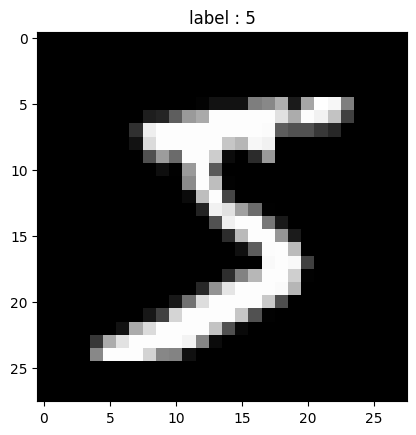

In [ ]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()

In [ ]:
# hyperparameter 설정

batch_size = 50 #--> 몇 개의 데이터를 한번에 모아서 가중치를 업데이트하는 계산에 사용할 것인가
epochs = 20
learning_rate = 0.0001

> PyTorch에서 DataLoader 만들기 - `torch.utils.data.DataLoader` 사용

- `torch.utils.data.DataLoader`는 기본적으로 아래 두 가지 인수를 받는다.

    1. `torch.utils.data.dataset.Dataset` : data generator

    2. batch_size

- `torch.utils.data.DataLoader`의 기능은 generator에서 batch_size 만큼의 데이터 샘플을 얻는 것이다.

    ```python
    train_loader = torch.utils.data.DataLoader(
        dataset=datasets.MNIST(root='dataset/', download=True, train=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,)) #--> (img - mean) / std
                            ])),
        batch_size=batch_size,
        shuffle=True)
        
    test_loader = torch.utils.data.DataLoader(
        dataset=datasets.MNIST(root='dataset', train=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.,), (1.))
                            ])),
        batch_size=test_batch_size,
        shuffle=True)
    ```

In [ ]:
# mini batch 구성 설정

# shuffle의 의미는 데이터의 순서를 학습하지 못하게 하는 것이다.
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# 첫번째 묶음(batch)를 가져와 확인
first_batch = train_loader.__iter__().__next__()
type(first_batch), len(first_batch), first_batch #--> list, 2, ~

(list,
 2,
 [tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          ...,
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [

In [ ]:
image, label = first_batch

print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(image)), image.shape)) #--> pixel data
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(label)), label.shape)) #--> target

name            | type                      | size
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


### - model

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500) # in_features, out_features
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
```

In [ ]:
# nn.Conv2d(
#     in_channels: int, out_channels: int, kernel_size: _size_2_t, stride: _size_2_t = 1, padding: _size_2_t | str = 0,
#     dilation: _size_2_t = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros',
#     device: Any | None = None, dtype: Any | None = None
# ) -> None

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # in_channels: int, out_channels: int, kernel_size: _size_2_t(3x3), stride: _size_2_t = 1
        # padding='same' --> convolutional filter에 의해 이미지 사이즈가 줄어드는 것을 방지, how? 테두리에 0을 채워서
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
        self.dropout = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(3136, 1000) #--> 7 x 7 x 64 = 3136
        self.fc2 = nn.Linear(1000, 10) # in_features: int, out_features: int

    def forward(self, x): #--> 28 x 28
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #--> 14 x 14

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #--> 7 x 7

        x = self.dropout(x)
        x = torch.flatten(input=x, start_dim=1) #--> 7 x 7 x 64, 차원 변환만 시도
        x = self.fc1(x) #<-- 7 x 7 x 64
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(input=x, dim=1)

        return output

In [ ]:
model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (dropout): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [ ]:
model.conv1.weight.shape, model.conv1.bias.shape

(torch.Size([32, 1, 3, 3]), torch.Size([32]))

In [ ]:
model.conv2.weight.shape, model.conv2.bias.shape

(torch.Size([64, 32, 3, 3]), torch.Size([64]))

In [ ]:
model.fc1.weight.shape, model.fc1.bias.shape

(torch.Size([1000, 3136]), torch.Size([1000]))

In [ ]:
model.fc2.weight.shape, model.fc2.bias.shape

(torch.Size([10, 1000]), torch.Size([10]))

In [ ]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 14, 14]          18,496
         Dropout2d-3             [-1, 64, 7, 7]               0
            Linear-4                 [-1, 1000]       3,137,000
            Linear-5                   [-1, 10]          10,010
Total params: 3,165,826
Trainable params: 3,165,826
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 12.08
Estimated Total Size (MB): 12.40
----------------------------------------------------------------


In [ ]:
# 모델 학습

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

i = 1
model.train() #--> 모델 학습 선언 (실제 학습 X), model을 train 모드로 바꾼다.
for epoch in range(epochs):
    start_time_each_epoch = time.time()

    for data, target in train_loader:
        # print(data.shape) #--> data에는 batch로 묶은 50개의 이미지 정보가 담긴다.
        data = data.to(device) #--> x
        target = target.to(device) #--> y

        output = model(data) #--> y_hat

        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward() #--> Weight 역전파
        optimizer.step() #--> Wehght Update

        if i % 1000 == 0:
            print("time: {:.2f}s".format(time.time() - start_time_each_epoch))
            print("Train Step: {:>5d}  |  Loss: {:.4f}".format(i, loss.item()))
        i += 1

time: 8.54s
Train Step:  1000  |  Loss: 0.1117
time: 5.53s
Train Step:  2000  |  Loss: 0.1022
time: 5.36s
Train Step:  3000  |  Loss: 0.0717
time: 2.81s
Train Step:  4000  |  Loss: 0.0759
time: 1.38s
Train Step:  5000  |  Loss: 0.0462
time: 8.93s
Train Step:  6000  |  Loss: 0.0107
time: 7.41s
Train Step:  7000  |  Loss: 0.0086
time: 6.57s
Train Step:  8000  |  Loss: 0.0157
time: 4.15s
Train Step:  9000  |  Loss: 0.0076
time: 2.93s
Train Step: 10000  |  Loss: 0.0019
time: 1.39s
Train Step: 11000  |  Loss: 0.0024
time: 9.45s
Train Step: 12000  |  Loss: 0.0506
time: 7.55s
Train Step: 13000  |  Loss: 0.0029
time: 6.63s
Train Step: 14000  |  Loss: 0.0069
time: 5.26s
Train Step: 15000  |  Loss: 0.0141
time: 2.76s
Train Step: 16000  |  Loss: 0.0419
time: 1.42s
Train Step: 17000  |  Loss: 0.0079
time: 8.50s
Train Step: 18000  |  Loss: 0.0080
time: 8.13s
Train Step: 19000  |  Loss: 0.0030
time: 6.34s
Train Step: 20000  |  Loss: 0.0046
time: 4.15s
Train Step: 21000  |  Loss: 0.0010
time: 3.49s
T

In [ ]:
# 모델 평가

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('Test set Accuracy : {:.2f}%'.format(100 * correct / len(test_loader.dataset)))

Test set Accuracy : 99.20%


In [ ]:
output

tensor([[-2.1058e+01, -2.1245e+01, -1.9529e+01, -2.3757e+01, -1.5704e+01,
         -9.8209e+00, -4.9678e-03, -3.4623e+01, -5.3183e+00, -2.4585e+01],
        [-4.4295e+01, -3.4176e+01, -3.3236e+01, -4.4979e+01,  0.0000e+00,
         -3.0304e+01, -3.4165e+01, -3.2840e+01, -3.2639e+01, -2.7421e+01],
        [-2.7955e+01, -1.6183e+01, -1.6584e+01, -1.4804e+01, -2.9834e+01,
         -3.0927e+01, -4.7220e+01, -5.9605e-07, -1.9246e+01, -1.7724e+01],
        [-5.9605e-07, -2.1281e+01, -1.8699e+01, -3.1974e+01, -2.6193e+01,
         -2.6297e+01, -2.2216e+01, -2.5181e+01, -1.4422e+01, -2.2376e+01],
        [-3.6543e+01, -3.4940e+01, -3.9403e+01, -3.7081e+01,  0.0000e+00,
         -2.7821e+01, -2.8881e+01, -2.8764e+01, -2.2288e+01, -2.2060e+01],
        [-2.3590e+01, -1.6849e+01, -1.5739e+01, -2.4946e+01, -1.4535e+01,
         -2.3895e+01, -4.4782e+01, -1.3208e-04, -1.8541e+01, -8.9369e+00],
        [-2.0652e+01, -2.8311e+01, -1.3196e+01, -3.7193e-05, -2.2582e+01,
         -1.0834e+01, -2.2483e+0

In [ ]:
output.data

tensor([[-2.1058e+01, -2.1245e+01, -1.9529e+01, -2.3757e+01, -1.5704e+01,
         -9.8209e+00, -4.9678e-03, -3.4623e+01, -5.3183e+00, -2.4585e+01],
        [-4.4295e+01, -3.4176e+01, -3.3236e+01, -4.4979e+01,  0.0000e+00,
         -3.0304e+01, -3.4165e+01, -3.2840e+01, -3.2639e+01, -2.7421e+01],
        [-2.7955e+01, -1.6183e+01, -1.6584e+01, -1.4804e+01, -2.9834e+01,
         -3.0927e+01, -4.7220e+01, -5.9605e-07, -1.9246e+01, -1.7724e+01],
        [-5.9605e-07, -2.1281e+01, -1.8699e+01, -3.1974e+01, -2.6193e+01,
         -2.6297e+01, -2.2216e+01, -2.5181e+01, -1.4422e+01, -2.2376e+01],
        [-3.6543e+01, -3.4940e+01, -3.9403e+01, -3.7081e+01,  0.0000e+00,
         -2.7821e+01, -2.8881e+01, -2.8764e+01, -2.2288e+01, -2.2060e+01],
        [-2.3590e+01, -1.6849e+01, -1.5739e+01, -2.4946e+01, -1.4535e+01,
         -2.3895e+01, -4.4782e+01, -1.3208e-04, -1.8541e+01, -8.9369e+00],
        [-2.0652e+01, -2.8311e+01, -1.3196e+01, -3.7193e-05, -2.2582e+01,
         -1.0834e+01, -2.2483e+0

In [ ]:
output.data.shape

torch.Size([50, 10])

In [ ]:
output.data.max(1)

torch.return_types.max(
values=tensor([-4.9678e-03,  0.0000e+00, -5.9605e-07, -5.9605e-07,  0.0000e+00,
        -1.3208e-04, -3.7193e-05, -1.4424e-05,  0.0000e+00, -6.2630e-03,
        -3.5763e-07, -7.7486e-06, -1.3970e-04,  0.0000e+00, -2.5801e-02,
        -4.7684e-07,  0.0000e+00,  0.0000e+00, -1.4186e-05, -1.0967e-05,
        -5.9605e-07,  0.0000e+00, -2.3842e-07, -5.9605e-07, -1.1921e-07,
         0.0000e+00, -1.3113e-05,  0.0000e+00,  0.0000e+00, -5.6028e-06,
         0.0000e+00, -2.0266e-06, -3.5763e-07,  0.0000e+00,  0.0000e+00,
        -2.6345e-05, -2.2695e-04,  0.0000e+00, -2.3842e-07, -4.7684e-07,
        -1.4305e-06, -2.3842e-07, -2.3805e-01,  0.0000e+00, -4.7684e-07,
        -3.5763e-07, -1.6689e-06,  0.0000e+00,  0.0000e+00, -2.2754e-04],
       device='cuda:0'),
indices=tensor([6, 4, 7, 0, 4, 7, 3, 3, 7, 3, 0, 6, 4, 0, 1, 3, 8, 5, 7, 0, 9, 2, 8, 9,
        9, 4, 9, 3, 8, 7, 8, 1, 5, 8, 6, 9, 1, 2, 9, 4, 7, 4, 5, 3, 0, 1, 4, 8,
        2, 9], device='cuda:0'))

In [ ]:
# output.data.max(1).shape
# AttributeError: 'torch.return_types.max' object has no attribute 'shape'

output.data.max(1)[0].shape, output.data.max(1)[1].shape

(torch.Size([50]), torch.Size([50]))

In [ ]:
output.data.max(1)[1]

tensor([6, 4, 7, 0, 4, 7, 3, 3, 7, 3, 0, 6, 4, 0, 1, 3, 8, 5, 7, 0, 9, 2, 8, 9,
        9, 4, 9, 3, 8, 7, 8, 1, 5, 8, 6, 9, 1, 2, 9, 4, 7, 4, 5, 3, 0, 1, 4, 8,
        2, 9], device='cuda:0')

In [ ]:
pred = output.data.max(1)[1]
pred

tensor([6, 4, 7, 0, 4, 7, 3, 3, 7, 3, 0, 6, 4, 0, 1, 3, 8, 5, 7, 0, 9, 2, 8, 9,
        9, 4, 9, 3, 8, 7, 8, 1, 5, 8, 6, 9, 1, 2, 9, 4, 7, 4, 5, 3, 0, 1, 4, 8,
        2, 9], device='cuda:0')

In [ ]:
pred.eq(target.data)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')

In [ ]:
pred.eq(target.data).sum()

tensor(48, device='cuda:0')

In [ ]:
correct = 0
correct += pred.eq(target.data).sum()
correct

tensor(48, device='cuda:0')

In [ ]:
for epoch in range(10):
    # Train Mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.item() #, end="\r"
            ))

    test_loss = 0
    correct = 0

    # Evaluation Mode
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

## 예제: Plant Leaf - CNN

In [ ]:
import os
import time
import copy
import math
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary

### - dataset

In [ ]:
# -d --> 압축을 푸는 경로 지정

!unzip -qq "/content/drive/MyDrive/zero-base DS/DL/_data/dataset.zip" -d './dataset'

In [ ]:
original_dataset_dir = './dataset'
classes_list = os.listdir(original_dataset_dir)
classes_list

['Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot',
 'Pepper,_bell___Bacterial_spot',
 'Corn___healthy',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Apple___healthy',
 'Peach___healthy',
 'Potato___healthy',
 'Potato___Early_blight',
 'Cherry___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Corn___Common_rust',
 'Tomato___Early_blight',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Tomato___Target_Spot',
 'Grape___healthy',
 'Potato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Corn___Northern_Leaf_Blight',
 'Tomato___Leaf_Mold',
 'Grape___Black_rot',
 'Peach___Bacterial_spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Apple___Apple_scab',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Grape___Esca_(Black_Measles)',
 'Tomato___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Cherry___healthy',
 'Pepper,_bell___healthy']

In [ ]:
# 데이터 정리를 위한 목록 및 폴더 생성

base_dir = './splitted'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'valid')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

for cls in classes_list:
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(validation_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))

In [ ]:
# 데이터 분할 & 현황 확인
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)

    train_size = math.floor(len(fnames) * 0.6)
    valid_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)

    train_fnames = fnames[:train_size]
    print("Train size(",cls,")", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)

    valid_fnames = fnames[train_size:(train_size + valid_size)]
    print("Valid size(",cls,")", len(valid_fnames))
    for fname in valid_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)

    test_fnames = fnames[(train_size + valid_size):(train_size + valid_size + test_size)]
    print("Test size(",cls,")", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

Train size( Tomato___Late_blight ) 1145
Valid size( Tomato___Late_blight ) 381
Test size( Tomato___Late_blight ) 381
Train size( Tomato___Septoria_leaf_spot ) 1062
Valid size( Tomato___Septoria_leaf_spot ) 354
Test size( Tomato___Septoria_leaf_spot ) 354
Train size( Pepper,_bell___Bacterial_spot ) 598
Valid size( Pepper,_bell___Bacterial_spot ) 199
Test size( Pepper,_bell___Bacterial_spot ) 199
Train size( Corn___healthy ) 697
Valid size( Corn___healthy ) 232
Test size( Corn___healthy ) 232
Train size( Tomato___Spider_mites Two-spotted_spider_mite ) 1005
Valid size( Tomato___Spider_mites Two-spotted_spider_mite ) 335
Test size( Tomato___Spider_mites Two-spotted_spider_mite ) 335
Train size( Apple___healthy ) 987
Valid size( Apple___healthy ) 329
Test size( Apple___healthy ) 329
Train size( Peach___healthy ) 216
Valid size( Peach___healthy ) 72
Test size( Peach___healthy ) 72
Train size( Potato___healthy ) 91
Valid size( Potato___healthy ) 30
Test size( Potato___healthy ) 30
Train size(

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

# Hyperparemeters
batch_size = 256
epochs = 30
learning_rate = 1e-3

cuda


In [ ]:
transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
train_dataset = ImageFolder(root='./splitted/train', transform=transform_base)
valid_dataset = ImageFolder(root='./splitted/valid', transform=transform_base)

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 23989
    Root location: ./splitted/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
sample, target = train_dataset[0]
sample.shape, target

(torch.Size([3, 64, 64]), 0)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True #, num_workers=2
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=True #, num_workers=2
)

In [ ]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 23989
    Root location: ./splitted/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
train_loader.dataset.classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

### - model : LeNET

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(4096, 512)
        self.fc2 = nn.Linear(512, 33) #--> class가 33개임.


    def forward(self, x):
        x = self.conv1(x) #--> 64 x 64
        x = F.relu(x)
        x = self.pool(x) #--> 32 x 32
        x = F.dropout(x, p=0.25, training=self.training) #--> train data만 적용

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x) #--> 16 x 16
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x) #--> 8 x 8
        x = F.dropout(x, p=0.25, training=self.training)

        x = x.view(-1, 4096) #--> Flatten과 동일, 8 x 8 x 64
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [ ]:
# 학습 함수
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) #--> data, target을 Device로 보낸다.

        output = model(data)

        optimizer.zero_grad()
        loss = F.cross_entropy(output, target)
        loss.backward() #--> 역전파
        optimizer.step() #--> weight update

In [ ]:
# 평가 함수
def evaluate(model, test_loader):
    model = model.to(DEVICE)
    test_loss = 0
    correct = 0

    model.eval()
    with torch.no_grad(): #--> 모델을 평가할 때는 가중치를 업데이트하면 안된다.
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
def train_baseline(model, train_loader, valid_loader, optimizer, num_epochs = 30):
    # 정확도가 가장 높은 모델의 가중치를 저장하기 위한 변수 생성
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(1, num_epochs+1):
        since = time.time()
        # 학습
        train(model, train_loader, optimizer)
        # 평가
        train_loss, train_acc = evaluate(model, train_loader)
        valid_loss, valid_acc = evaluate(model, valid_loader)

        # 30번째 epoch의 모델이 Best 모델이라는 보장이 없다.
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('-------------- epoch {} --------------'.format(epoch))
        print(' train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))
        print(' valid Loss: {:.4f}, Accuracy: {:.2f}%'.format(valid_loss, valid_acc))
        print(' Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
base_model = LeNet().to(DEVICE)
base_model

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=33, bias=True)
)

In [ ]:
params = base_model.state_dict()
params

OrderedDict([('conv1.weight',
              tensor([[[[-9.1004e-02,  5.6758e-02, -1.5857e-01],
                        [-8.5541e-02,  1.6194e-01,  9.2951e-02],
                        [ 4.0769e-03,  1.8122e-01, -1.7190e-01]],
              
                       [[ 4.0967e-02,  2.3315e-02, -3.2198e-02],
                        [ 6.9519e-02,  1.5575e-01, -4.6907e-02],
                        [ 3.7315e-02, -1.5148e-01, -8.0824e-02]],
              
                       [[-1.5503e-01,  5.0321e-02, -1.2576e-01],
                        [ 8.1423e-02, -7.2092e-02,  4.8414e-02],
                        [ 6.0434e-02, -7.0823e-02,  2.2370e-02]]],
              
              
                      [[[-6.0418e-02,  4.9522e-02,  1.7878e-01],
                        [-1.6397e-01,  1.2920e-01,  1.8467e-01],
                        [ 1.3852e-01, -1.6954e-01, -7.4212e-02]],
              
                       [[-1.4724e-02, -1.6045e-01,  3.8353e-03],
                        [-1.0776e-01,  2.1697

In [ ]:
params['conv1.weight'].shape, params['conv1.bias'].shape

(torch.Size([32, 3, 3, 3]), torch.Size([32]))

In [ ]:
base_model.conv1.weight.shape, base_model.conv1.bias.shape

(torch.Size([32, 3, 3, 3]), torch.Size([32]))

In [ ]:
params['conv2.weight'].shape, params['conv2.bias'].shape

(torch.Size([64, 32, 3, 3]), torch.Size([64]))

In [ ]:
params['conv3.weight'].shape, params['conv3.bias'].shape

(torch.Size([64, 64, 3, 3]), torch.Size([64]))

In [ ]:
params['fc1.weight'].shape, params['fc1.bias'].shape

(torch.Size([512, 4096]), torch.Size([512]))

In [ ]:
params['fc2.weight'].shape, params['fc2.bias'].shape

(torch.Size([33, 512]), torch.Size([33]))

In [ ]:
# 모델 요약 출력
summary(base_model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                  [-1, 512]       2,097,664
            Linear-8                   [-1, 33]          16,929
Total params: 2,170,913
Trainable params: 2,170,913
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 2.04
Params size (MB): 8.28
Estimated Total Size (MB): 10.36
----------------------------------------------------------------


In [ ]:
optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)

best_model = train_baseline(base_model, train_loader, valid_loader, optimizer, epochs)

-------------- epoch 1 --------------
 train Loss: 1.5704, Accuracy: 54.62%
 valid Loss: 1.5867, Accuracy: 54.36%
 Completed in 1m 20s
-------------- epoch 2 --------------
 train Loss: 1.0351, Accuracy: 67.79%
 valid Loss: 1.0804, Accuracy: 66.10%
 Completed in 1m 15s
-------------- epoch 3 --------------
 train Loss: 0.8190, Accuracy: 74.00%
 valid Loss: 0.8811, Accuracy: 72.90%
 Completed in 1m 15s
-------------- epoch 4 --------------
 train Loss: 0.6144, Accuracy: 80.41%
 valid Loss: 0.6895, Accuracy: 78.52%
 Completed in 1m 15s
-------------- epoch 5 --------------
 train Loss: 0.4461, Accuracy: 85.57%
 valid Loss: 0.5352, Accuracy: 83.61%
 Completed in 1m 14s
-------------- epoch 6 --------------
 train Loss: 0.3493, Accuracy: 89.03%
 valid Loss: 0.4550, Accuracy: 85.82%
 Completed in 1m 15s
-------------- epoch 7 --------------
 train Loss: 0.2838, Accuracy: 91.56%
 valid Loss: 0.4044, Accuracy: 87.55%
 Completed in 1m 15s
-------------- epoch 8 --------------
 train Loss: 0.27

In [ ]:
torch.save(best_model, '/content/drive/MyDrive/zero-base DS/DL/pytorch_plant_leaf_best_model.pt')

In [ ]:
test_dataset = ImageFolder(root='./splitted/test', transform=transform_base)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True
)

In [ ]:
test_loss, test_acc = evaluate(best_model, test_loader)
print('Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(test_loss, test_acc))

Test Loss: 0.2025, Accuracy: 93.72%


### - TL/FT : ResNET-50

- ResNet-50 모델을 이용한 전이 학습(Transfer Learning) 및 미세 조정(fine-tuning)

- ImageNet의 1000개의 클래스로 구성된 대규모 데이터셋에 대해 훈련된 모델의 가중치를 사용

In [ ]:
from torchvision import models
from torch.optim import lr_scheduler

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [ ]:
data_tansforms = {
	'train': transforms.Compose([
		transforms.Resize([64,64]),
		transforms.RandomHorizontalFlip(),
		transforms.RandomVerticalFlip(),
		transforms.RandomCrop(52),
		transforms.ToTensor(),
		transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
	]),
	'valid': transforms.Compose([
		transforms.Resize([64,64]),
		transforms.RandomCrop(52),
		transforms.ToTensor(),
		transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
	]),
	'test': transforms.Compose([
		transforms.Resize([64,64]),
        transforms.RandomCrop(52),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
	])
}
# transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# RGB의 평균과 표준편차 값을 지정해 정규화한다. --> 색상이 있는 이미지의 학습능력이 좋아진다.

In [ ]:
data_dir = './splitted'
image_datasets = {
	x: ImageFolder(root=os.path.join(data_dir, x), transform=data_tansforms[x]) for x in ['train', 'valid', 'test']
}
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 23989
     Root location: ./splitted/train
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                RandomCrop(size=(52, 52), padding=None)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 7989
     Root location: ./splitted/valid
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=True)
                RandomCrop(size=(52, 52), padding=None)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 7989
     Root location: ./

In [ ]:
data_loaders = {
	x: torch.utils.data.DataLoader(
		image_datasets[x], batch_size=256, shuffle=True
	) for x in ['train', 'valid', 'test']
}
data_loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x792abb4882e0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x792abb488400>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x792abb488940>}

In [ ]:
data_loaders['train'].dataset

Dataset ImageFolder
    Number of datapoints: 23989
    Root location: ./splitted/train
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomCrop(size=(52, 52), padding=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
dataset_sizes

{'train': 23989, 'valid': 7989, 'test': 7989}

In [ ]:
class_names = image_datasets['train'].classes
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
# 🚩Pre-trained Model 불러오기
# resnet = models.resnet50(pretrained=True) #--> pretrained=True 이면 학습이 완료된 weights를 가져오고 False이면 모델 구조만 가져온다.
# UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
# The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`.
# You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.

resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


In [ ]:
resnet = resnet.to(DEVICE)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(resnet, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
resnet.fc.in_features, resnet.fc.out_features

(2048, 1000)

In [ ]:
# ResNET 모델의 fully connected layer의 input features가 몇 개인지 확인한 후
# 맨 마지막 출력단(fully connected layer)를 잘라내고 내 데이터의 class 33개에 맞는 layer로 바꾼다.
# 이렇게 바꾼 마지막 layer는 학습이 안되어 있으므로 이후 학습이 필요하다.

resnet.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=33)

In [ ]:
resnet.children() #--> 모델에 속해있는 하위 레벨의 Layer 정보를 가져온다.

<generator object Module.children at 0x7f6000684190>

In [ ]:
next(iter(resnet.children()))

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
for i, child in enumerate(resnet.children()):
    if i < 6:
        print(i)
        print(child)
    else:
        print(i)

0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2
ReLU(inplace=True)
3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [ ]:
# 0번부터 5번까지 layer를 freeze시켜 학습시키지 않는다.
# 입력에 가까운 5개의 layer를 고정시킨다.
for i, child in enumerate(resnet.children()):
    if i < 6:
        for param in child.parameters():
            param.requires_grad = False
    else:
        break

In [ ]:
# 6번 layer 부터 마지막 fc layer 까지 학습
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)

# 지정된 주기(step_size)마다 학습률을 주어진 비율(gamma)만큼 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#### __lr_scheduler__

`lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)`는 PyTorch의 학습률 스케줄러 중 하나인 `StepLR`을 생성합니다.

이 스케줄러는 지정된 주기(step_size)마다 학습률을 주어진 비율(gamma)만큼 감소시킵니다.

- `optimizer_ft`: 이 스케줄러에 적용할 최적화기(optimizer)입니다.

- `step_size`: 학습률을 감소시킬 주기를 지정합니다.

    예를 들어, `step_size=7`은 매 7번의 epoch마다 학습률을 감소시키겠다는 것을 의미합니다.

- `gamma`: 감소할 학습률의 비율을 나타냅니다.

    예를 들어, `gamma=0.1`은 각 주기마다 학습률을 10% 감소시키겠다는 것을 의미합니다. <br></br>

이러한 학습률 스케줄러는 모델의 학습 과정 중에 학습률을 동적으로 조절하여 더 나은 수렴을 도와줍니다.

일반적으로 학습 초기에는 높은 학습률을 사용하여 빠르게 수렴하도록 하고, 학습이 진행됨에 따라 학습률을 감소시켜 최적점에 미세하게 접근하도록 하는 데 사용됩니다.

</br>

-----

</br>

```python
optimizer = optim.SGD(model.parameters(), lr=0.003)
```

```python
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Loss를 사용할 경우, mode='min'
# Accuracy를 사용할 경우, mode='max'
scheduler = ReduceLROnPlateau(optimizer, mode='min')
```
- Train Loop을 epoch 만큼 도는 동안 loss 값이 변동이 없다고 판단되면

    scheduler가 learning_rate를 일정 비율로 줄여 준다.

```python
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, epoch):
    model.train()
    size = len(dataloader)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            print(f"Epoch {epoch+1} : [{batch}/{size}] loss : {loss.item()}")

    scheduler.step(loss)
    return loss.item()

for epoch in range(10):
    loss = train_loop(train_loader, model, F.nll_loss, optimizer, scheduler, epoch)
    print(f"epoch:{epoch+1} --> loss:{loss}" )
```

In [ ]:
def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):
    model.to(DEVICE)
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict()) #--> 모델의 weights를 가져온다.

    for epoch in range(num_epochs):
        print('--------------- epoch {} ---------------'.format(epoch+1))
        since = time.time()
        for phase in ['train', 'valid']:
            if phase == 'trian':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # mini batch size inputs & outputs
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim=1)
                    # torch.max(input, dim=None, keepdim=False, out=None) -> tuple(val, idx)
                    # return: 해당 차원(dim)의 최대값과 최대값의 위치(인덱스)
                    # index가 곧 분류 class가 되므로 preds에는 예측된 class값이 저장된다.
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0) #--> 설정된 batch_size이다.
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(' {} Loss: {:.4f}, Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print(' Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('{}\n Best valid Accuracy : {:.2f}% \n{}'.format('='*30, best_acc*100, '='*30))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
best_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epochs)

--------------- epoch 1 ---------------
 train Loss: 3.1262, Accuracy: 0.1509
 valid Loss: 2.2835, Accuracy: 0.2850
 Completed in 1m 12s
--------------- epoch 2 ---------------
 train Loss: 1.4214, Accuracy: 0.5333
 valid Loss: 0.7728, Accuracy: 0.7404
 Completed in 1m 11s
--------------- epoch 3 ---------------
 train Loss: 0.4708, Accuracy: 0.8400
 valid Loss: 0.3779, Accuracy: 0.8737
 Completed in 1m 18s
--------------- epoch 4 ---------------
 train Loss: 0.2762, Accuracy: 0.9055
 valid Loss: 0.2349, Accuracy: 0.9191
 Completed in 1m 12s
--------------- epoch 5 ---------------
 train Loss: 0.1848, Accuracy: 0.9368
 valid Loss: 0.1648, Accuracy: 0.9437
 Completed in 1m 20s
--------------- epoch 6 ---------------
 train Loss: 0.1350, Accuracy: 0.9526
 valid Loss: 0.1630, Accuracy: 0.9462
 Completed in 1m 16s
--------------- epoch 7 ---------------
 train Loss: 0.1306, Accuracy: 0.9555
 valid Loss: 0.1304, Accuracy: 0.9568
 Completed in 1m 10s
--------------- epoch 8 ---------------
 

In [ ]:
test_loss, test_acc = evaluate(best_resnet50, data_loaders['test'])
print('ResNet50 Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(test_loss, test_acc))

ResNet50 Test Loss: 0.0578, Accuracy: 98.06%


- `.pt`와 `.pth` 확장자 모두 PyTorch 모델을 저장하는 데 사용할 수 있으며,

    이 두 확장자 간에는 실질적인 차이는 없다.

</br>

- 모델의 전체 구조와 가중치 저장
    ```python
    import torch

    # 모델 저장
    torch.save(model, 'model.pth')

    # 모델 로드
    model = torch.load('model.pth')
    ```

- 학습된 가중치만 저장
    ```python
    import torch

    # 모델의 상태 사전 추출하여 저장
    torch.save(model.state_dict(), 'model_weights.pth')

    # 모델의 구조를 만들기
    model = YourModelClass()

    # 저장된 가중치를 모델에 로드하기
    model.load_state_dict(torch.load('model_weights.pth'))
    ```

In [ ]:
# torch.save(best_resnet50, '/content/drive/MyDrive/zero-base DS/DL/pytorch_plant_leaf_best_resnet50.pt')
# AttributeError: Can't pickle local object 'summary.<locals>.register_hook.<locals>.hook'
# 모델 구조를 저장하려고 할 때 오류 발생

In [ ]:
# 가중치만 저장함.
torch.save(best_resnet50.state_dict(), '/content/drive/MyDrive/zero-base DS/DL/pytorch_plant_leaf_best_resnet50_weights.pth')

In [ ]:
# 1. 모델 구조만 가져오기
resnet50 = models.resnet50(weights=None)
resnet50.fc = nn.Linear(in_features=resnet50.fc.in_features, out_features=33)

In [ ]:
# 2. 저장해둔 best resnet50 weights 가져와 모델 구조에 반영하기
resnet50.load_state_dict(torch.load('/content/drive/MyDrive/zero-base DS/DL/pytorch_plant_leaf_best_resnet50_weights.pth'))

<All keys matched successfully>

In [ ]:
resnet50 = resnet50.to(DEVICE)
test_loss, test_acc = evaluate(resnet50, data_loaders['test'])
print('ResNet50 Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(test_loss, test_acc))

ResNet50 Test Loss: 0.0538, Accuracy: 98.30%


In [ ]:
transform_resNet = transforms.Compose([
	transforms.Resize([64,64]),
	transforms.ToTensor(),
	transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_resNet = ImageFolder(root='./splitted/test', transform=transform_resNet)
test_loader_resNet = torch.utils.data.DataLoader(
	test_resNet, batch_size=batch_size, shuffle=True
)
test_loss, test_acc = evaluate(resnet50, test_loader_resNet)
print('ResNet50 Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(test_loss, test_acc))

ResNet50 Test Loss: 0.0613, Accuracy: 98.06%


<br></br>

---

<br></br>

# Framework

## 데이터 다루기

In [42]:
import os
import numpy as np
from glob import glob
from PIL import Image

import torch
from torchvision import datasets, transforms

torch.manual_seed(27)

### - local dataset

> 로컬에 있는 데이터를 torch.utils.data.dataset.Dataset 으로 만들기

</br>

#### __ImageFolder__

- ImageFolder : 간단하게 로컬에 있는 이미지 데이터셋을 불러올 수 있다.

    단, 디렉토리 구조는 다음과 같아야 한다.

    - dataset
        - class0</br>
            － xx.png</br>
            － yy.png</br>
            － ...</br>
        - class1</br>
            － xx.png</br>
            － yy.png</br>
            － ...</br>
        - class2</br>
            － xx.png</br>
            － yy.png</br>
            － ...</br>

In [ ]:
train_dir = "D:/zbDS/Project/Part8_DL/_dataset/mnist_png/training/"
test_dir = "D:/zbDS/Project/Part8_DL/_dataset/mnist_png/testing/"

train_dataset = datasets.ImageFolder(
	root=train_dir,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
)
test_dataset = datasets.ImageFolder(
	root=test_dir,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
)

In [ ]:
train_loader = torch.utils.data.DataLoader(
	train_dataset, batch_size=32, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
	test_dataset, batch_size=32
)

### - custom dataset

> 직접 `torch.utils.data.Dataset`을 상속받아서 데이터셋 구현하기

- Dataset sub-class

In [ ]:
cifar_dir = '/content/drive/MyDrive/zero-base DS/DL/_data/cifar/'

os.listdir(cifar_dir)

In [ ]:
train_dir = cifar_dir + 'train'
test_dir = cifar_dir + 'test'

In [ ]:
train_paths = glob(train_dir + "/*.png")
test_paths = glob(test_dir + "/*.png")

In [ ]:
with open(os.path.join(cifar_dir, 'labels.txt'), 'r') as f:
    label_list = f.read()

label_list

In [ ]:
label_list = label_list.strip().split('\n')
print(label_list)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_paths, transform=None):
        super(Dataset).__init__()
        self.data_paths = data_paths
        self.transform = transform

    def __len__(self, ):
        return len(self.data_paths)


    # index를 입력하면 해당하는 데이터를 파싱해서 이미지와 레이블로 만들어 주는 메서드
    def __getitem__(self, idx):
        path = self.data_paths[idx]
        image = Image.open(path)
        label_name = path.split(".png")[0].split("_")[-1].strip()
        label = label_list.index(label_name)

        if self.transform:
            image = self.transform(image)

        return image, label

이 코드에서는 데이터셋을 만들 때 이미지 파일의 경로를 리스트로 저장하고 있습니다. 이렇게 저장된 이미지들은 데이터셋의 `__getitem__` 메서드에서 필요할 때마다 실제로 불러와서 사용됩니다. 이러한 방식으로는 전체 데이터셋이 한 번에 메모리에 로드되지 않습니다.

따라서 `train_loader`와 `test_loader`를 사용하여 데이터를 로드할 때, 실제로는 배치 크기(`batch_size`)에 따라 한 번에 해당 배치 크기만큼의 데이터만 메모리에 로드됩니다. 이는 PyTorch의 `DataLoader`가 배치 단위로 데이터를 로드하고 전달하기 때문에 가능합니다. 이러한 방식을 사용하면 메모리 효율적으로 대규모 데이터셋을 처리할 수 있습니다.

In [ ]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    Dataset(train_paths, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    Dataset(test_paths, transform=transforms.ToTensor()),
    batch_size=batch_size
)

### - dataset transform

In [38]:
dir(transforms) #--> 사용 가능한 transform 기능들

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

In [40]:
image = Image.open("/content/drive/MyDrive/zero-base DS/DL/_data/sample.jpg")
image.size # image.shape X

(1280, 1029)

In [43]:
np.array(image).shape

(1029, 1280, 3)

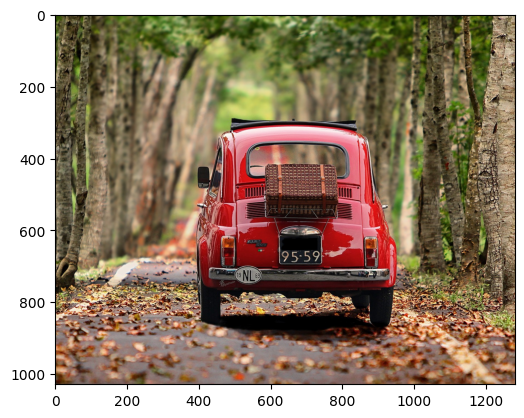

In [44]:
plt.imshow(image)
plt.show()

In [ ]:
transforms.Resize((512, 512))(image)

In [ ]:
transforms.RandomCrop(size=(512,512))(image)

In [ ]:
transforms.ColorJitter(brightness=1)(image)

In [ ]:
transforms.Grayscale()(image)

In [ ]:
transforms.Pad(padding=(20,10))(image)

In [ ]:
transforms.RandomAffine(degrees=90)(image)

In [ ]:
transforms.RandomHorizontalFlip(p=1.)(image)

In [ ]:
transform_list = [
	transforms.RandomAffine(degrees=90),
	transforms.Pad(padding=(20,20))
]

transforms.RandomApply(transform_list, p=0.5)(image)
# OR
transforms.RandomChoice(transforms=transform_list)(image)
# OR
transforms.Compose(transform_list)(image)

In [ ]:
cifar_dir = '/content/drive/MyDrive/zero-base DS/DL/_data/cifar/'
train_dir = os.path.join(cifar_dir, "train")
test_dir = os.path.join(cifar_dir, "test")

In [ ]:
train_transform = transforms.Compose([
	transforms.RandomResizedCrop(224),
	transforms.RandomHorizontalFlip(),
	transforms.ColorJitter(brightness=1, contrast=0, saturation=0, hue=0),
	transforms.Resize(224),
	transforms.ToTensor(),
	transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
	transforms.Resize(224),
	transforms.ToTensor(),
	transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# class Dataset(torch.utils.data.Dataset):

train_dataset = Dataset(data_paths=glob(train_dir + "/*.png"), transform=transform)
test_dataset = Dataset(data_paths=glob(test_dir + "/*.png"), transform=test_transform)

In [ ]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size
)

## 모델 학습 및 저장

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms

### - model train

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    dataset=datasets.MNIST(root='dataset/', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean=(0.5,), std=(0.5,))
                           ])),
    batch_size=batch_size,
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=datasets.MNIST(root='dataset', train=False,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.,), (1.))
                           ])),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ResidualBlock, self).__init__()

        self.in_channel, self.out_channel = in_channel, out_channel

        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=1, padding=0)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(out_channel, out_channel, kernel_size=1, padding=0)

        if in_channel != out_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, padding=0)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = out + self.shortcut(x)
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, color='gray'):
        super(ResNet, self).__init__()
        if color == "gray":
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        elif color == "rgb":
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)

        self.resblock1 = ResidualBlock(32, 64)
        self.resblock2 = ResidualBlock(64, 64)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
model = ResNet().to(device)

In [ ]:
epochs = 10
optimizer = optim.SGD(model.parameters(), lr=0.003)
scheduler = ReduceLROnPlateau(optimizer, mode='min')
# Loss를 사용할 경우, mode='min' / Accuracy를 사용할 경우, mode='max' 로 설정
# epoch를 도는 동안 loss 값이 변동이 없다고 판단되면 scheduler가 learning_rate를 일정 비율로 줄여 준다.

def train_loop(dataloader, model, loss_fn, optimizer, scheduler, epoch):
    model.train()
    size = len(dataloader)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            print(f"Epoch {epoch+1} : [{batch}/{size}] loss : {loss.item()}")

    scheduler.step(loss)

    return loss.item()

# 학습
# F.nll_loss: Compute the "negative log likelihood" loss.
# 모델의 출력층 활성함수인 F.log_softmax()와 함께 사용하면 One-Hot Encoding 효과를 볼 수 있다.
for epoch in range(epochs):
    loss = train_loop(train_loader, model, F.nll_loss, optimizer, scheduler, epoch)
    print(f"epoch:{epoch+1} --> loss:{loss}" )

Epoch 1 : [0/1875] loss : 2.285984992980957
Epoch 1 : [500/1875] loss : 2.314659595489502
Epoch 1 : [1000/1875] loss : 2.305518388748169
Epoch 1 : [1500/1875] loss : 2.3015615940093994
epoch:1 --> loss:2.3006670475006104
Epoch 2 : [0/1875] loss : 2.305032253265381
Epoch 2 : [500/1875] loss : 2.3018338680267334
Epoch 2 : [1000/1875] loss : 2.314079523086548
Epoch 2 : [1500/1875] loss : 2.301872730255127
epoch:2 --> loss:2.3003456592559814
Epoch 3 : [0/1875] loss : 2.3093950748443604
Epoch 3 : [500/1875] loss : 2.3125991821289062
Epoch 3 : [1000/1875] loss : 2.284093141555786
Epoch 3 : [1500/1875] loss : 2.289682149887085
epoch:3 --> loss:2.317432403564453
Epoch 4 : [0/1875] loss : 2.29801082611084
Epoch 4 : [500/1875] loss : 2.2909247875213623
Epoch 4 : [1000/1875] loss : 2.274104118347168
Epoch 4 : [1500/1875] loss : 2.3035976886749268
epoch:4 --> loss:2.302130699157715
Epoch 5 : [0/1875] loss : 2.2649011611938477
Epoch 5 : [500/1875] loss : 2.296720027923584
Epoch 5 : [1000/1875] loss

### - model save & load

In [ ]:
# model 저장
torch.save(model, 'model.pth')

# model 로드
model = torch.load('model.pth')
model

ResNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resblock1): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (shortcut): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (resblock2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (shortcut): Sequential()
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
# weights만 저장
torch.save(model.state_dict(), 'model_weights.pth')

# model 구조를 만들기
model = ResNet()

# 저장된 weights를 model에 로드하기
model.load_state_dict(torch.load('model_weights.pth'))
model

ResNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resblock1): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (shortcut): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (resblock2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (shortcut): Sequential()
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

### - train resume save & load

- 학습 이력을 저장하고 다시 로드해 이어서 학습을 재개할 수 있다.

In [ ]:
checkpoint_path = 'checkpoint.pth'

torch.save(obj={
    'epochs': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, f=checkpoint_path)

In [ ]:
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path) #--> dict type
checkpoint.keys()

dict_keys(['epochs', 'model_state_dict', 'optimizer_state_dict', 'loss'])

In [ ]:
epochs = checkpoint['epochs']
epochs

10

In [ ]:
model = ResNet().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model

ResNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resblock1): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (shortcut): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (resblock2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (shortcut): Sequential()
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer = optim.SGD(params=model.parameters(), lr=0.003)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.003
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [ ]:
loss = checkpoint['loss']
loss

2.022549629211426

👆 위 정보를 가지고 이어서 모델을 학습 시킬 수 있다.